### TMA4320 - Project 2: Physics


# 0.0 Motivation

In [101]:

# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from tempfile import TemporaryFile


# To show figures in the notebook
%matplotlib inline

# Make the figures more readable
newparams = {'figure.figsize': (18, 9), 'axes.grid': False,
             'lines.linewidth': 2,
             'font.size': 25, 'mathtext.fontset': 'stix',
             'font.family': 'STIXGeneral'}
# figure.figsize sets the size of the figure (values are in inches)
# axes.grid, set to False means that there is no grid
# lines.linewidth sets the thickness of the lines in the plot
# font.size sets the size of the text (ticks, title, xlabel, etc.)
# mathtext.fontset sets the font of the text of the type r'$tekst$' (math text)
# font.family sets the font of ordinary text (ticks, title, xlabel, etc.)

# There are several other parameters you can change, and you can look them up in the documentation 
# for matplotlib if you need to change any. 

plt.rcParams.update(newparams) # Updates the parameter set above. 

In [102]:
# Parameters
sigma_0 = 1000 # kg/m^2
sigma = 500 # kg/m^2
R = 10 # m, Radius
A_s = 0.5*np.pi*(R**2) # Cross-section of boat
g = 9.81 # m/s^2
h = (4*R)/(3*np.pi)
m_boat = A_s*sigma

A_0 = (sigma*np.pi*(R**2))/(2*sigma_0)


For å undersøke båtens endring i hellingsvinkel

In [103]:
def calculate_I_c(m_load, s_L):
    '''
    This function calculated the ships total rotational inertia of the ship and its load, at the
    relative position of the load affects the total rotational inertia.
    Input:
        m_load: float, the mass of the load [kg]
        s_L:    float, the loads distance from the metacenter [m]
    Output:
        I_c:    float, the ships total rotational inertia [kg/m²]
    '''
    I_boat = 0.5*m_boat*(R**2)*(1-(32/(9*(np.pi**2)))) # Rotational inertia from the ship about C

    r_load = np.sqrt( h**2 + s_L**2 ) # Distance from ship's CM to load's CM
    I_load = m_load*r_load**2   # Rotational inertia from the load about C 
    
    I_c = I_load + I_boat # Use the superposition property of rotational inertias (Steiner's Thm).
    return I_c


# print(calculate_I_c(0.001*m_boat, 0))
# print(calculate_I_c(0.001*m_boat, R))

In [104]:
def calculate_beta(rhs_constant, x0, tol=1.e-8, max_iter=50):
    ''' Given a right hand side and left hand side of a function and its derivatives, calculates the beta value of the function.
    
    Solve f(x)=0 by Newtons method, 
    
        The output of each iteration is printed
        Input:
        f_lhs: left hand side of function
        df_lhs: left hand side of derivative of function
        f_rhs: right hand side of function
        df_rhs: right hand side of derivative of function
        x0:  Initial values
        tol: The tolerance
      Output:
        The root and the number of iterations
    '''

    f = lambda beta: beta - np.sin(beta) - rhs_constant
    df = lambda beta: 1 - np.cos(beta)


    x = x0
    for k in range(max_iter):
        fx = f(x)
        if abs(fx) < tol:           # Accept the solution 
            break 
        x = x - fx/df(x)            # Newton-iteration
    return x

In [105]:
def print_beta():
    f_lhs = lambda beta: beta-np.sin(beta)
    df_lhs = lambda beta: 1 - np.cos(beta)

    f_rhs = lambda beta : np.pi * sigma/sigma_0
    df_rhs = 0

    beta = calculate_beta(np.pi*sigma/sigma_0,5)
    print("Beta = ",round(np.degrees(beta), 2),"degrees")
print_beta()

Beta =  132.35 degrees


In [106]:
#Define the global variables for the equilibrium, as requested in 1b)
y_M_0 = lambda beta: R*np.cos(beta/2)
y_C_0 = lambda beta: y_M_0(beta) - 4*R/(3*np.pi)
y_B_0 = lambda beta: y_M_0(beta) - 4*R*(np.sin(beta/2))**3 /(3*(beta-np.sin(beta)))
y_D_0 = lambda beta: y_M_0(beta) - R

#Values as functions of delta y_C and theta. 
y_M = lambda beta, theta, delta_y_C : y_M_0(beta) + ((4*R)/(3*np.pi))*(np.cos(theta)-1) + delta_y_C
y_C = lambda beta,delta_y_c : y_C_0(beta) + delta_y_c
y_D = lambda beta, theta, delta_y_c : y_D_0(beta) + ((4*R)/(3*np.pi))*(np.cos(theta)-1) + delta_y_c
y_B = lambda beta: y_B_0(beta)

#Note: beta is a global variable
gamma = lambda beta, theta, delta_y_c : 2*np.arccos(np.cos(beta/2)-(4/(3*np.pi))*(1-np.cos(theta))+delta_y_c/R)

water_area = lambda gamma_number: 0.5*(R**2)*(gamma_number - np.sin(gamma_number))

F_G = lambda m : -m*g
F_B = lambda A : A*sigma_0*g
friction = lambda k_f, omega, gamma_number : -k_f * R * gamma_number*omega


## 0.? Visualisering av data

For å analysere opparbeidete resultater er det hensiktsmessig å visualisere det i plot. Derfor definerer vi en fleksibel funksjon som plotter datasett på en foretrukket måte. Denne vil bli brukt gjennomgående i rapporten.


# 1.3 Euler metoden


In [107]:
def euler_step(f, t, w, h_step):
    '''
    Tar inn en vektor-funksjon på formen w = [theta(t), omega(t)], med nåværende tid (t) og 
    tilstand (w), og regner ut ett Euler-steg.
    Inn:
        f: s-array, som beskriver et system av førsteordens diff-ligninger.
        t: float, nåvernde tid
        w: s-array, som beskriver systemet
        h_step: steglengde
    Ut:
        t_new: neste tidssteg (t+h)
        w_new: systemet etter ett beregnet tidssteg    
    '''
    
    w_new = w + h_step*f(t, w)
    return t, w_new

In [108]:
def solve_ODE_old(f, t_0, t_end, w_0, h_step, method):
    '''
    Funksjon som løser diff-liking ved å benytte Euler-metoden.
    Inn:
        f: s-array, som beskriver et system av førsteordens diff-ligninger.
        t_0: float, starttid
        t_end: float, slittid
        w_0: s-array, som systemets startposisjon
        h_step: steglengde
    Ut:
        t_num: array, tidsstegene
        w_num: s-array, de beregnede verdiene for theta of omega    
    '''
    w_num = np.array([w_0])  
    t_num = np.arange(t_0, t_end + h_step, h_step)   
    t,w_n = method(f, t_num[0], w_num[0], h_step)
    w_num = np.concatenate((w_num, np.array([w_n])))
    for i in range(1,len(t_num)-1):#ikke inkl første element
        if t_num[-1] > t_end- 1.0e-10: #For å treffe endepunktet. 10e-10 for å unngå "truncation error"
            t_num[-1] = t_end
        
        t,w_n = method(f, t_num[i], w_num[i], h_step)
        
        w_num = np.concatenate((w_num, np.array([w_n])))
    #print(t_num)
    return t_num, w_num

In [189]:
# New solve_ode
def solve_ODE(f, t_0, t_end, w_0, h_0, method, fixed_step = True, tol = 1e-6, max_iter = 1e5):
    '''
    Funksjon som løser differensial ligninger på en brukerdefinert måte.
    Inn:
        f: s-array, som beskriver et system av førsteordens diff-ligninger.
        t_0: float, starttid
        t_end: float, slittid
        w_0: s-array, som systemets startposisjon
        h_0: Dersom vi ønsker dynamisk steglengde vil dette være startsteglengden
            ellers blir dette den konstante steglengden
        tol: The tollerance if we wish to use adaptive step size
    Ut:
        t_num: array, tidsstegene
        w_num: s-array, de beregnede verdiene for theta of omega    
    '''
    t_num = np.array([t_0])
    w_num = w_0
    # Set the running values
    t_n = t_0
    w_i = w_0
    h_step = h_0
    

    if fixed_step:
        N = int( (t_end-t_0)/h_step + 1) 
        t_num = np.linspace(t_0, t_end, N)  # Use linpace, as numpys documentation suggests this for
                                            # non-integer values, we also get the closed interval [t_0, t_end].
        # print(f't_num:\n {t_num}\n t_num minus one:\n {t_num[0:-1]}')        

        # This loop will iterate over all the t-values exept the last one. The reason for this is because the w corresponding
        # to the last t-value is calculated at the second last t-value, and so, both arrays have an equal lenght.
        print(t_num[0:])
        #for i, t_n in enumerate(t_num[0:-1]): 
        for i, t_n in enumerate(t_num[0:]): 
            w_i = method(f, t_n, w_i, h_step)[1] # Here we are only interrested in w, as the step size is fixed
            #print("w_i[3] in f", w_i[3])
            # print(f'w_num:\n {w_num}\n\n w_{i+1}:\n {w_n}\n\n\n\n ')
            w_num = np.concatenate(( w_num, w_i), axis=1)

    else: 
        current_iter = 0
        while t_n < t_end-1e-10: # take truncation error into account        
            if t_n + h_step > t_end:
                h_step = t_end-t_n
                
            # One step with the method:
            t_try, w_try, err_est, p = method(f, t_n, w_n, h_step)
            current_f_calls += 1
            
            if err_est <= tol:
                # Use the solution
                t_n = t_try
                w_n = w_try
                
                # Store the solutions
                t_num = np.append(t_num, t_n)           
                w_num = np.concatenate((w_num, np.array([w_n])))
                
            
            # Adjust the step size, start by defining facors
            P = 0.8 # Pessismist facor, normally between 0.5 and 0.95
            
            h_step = P*( (tol/err_est)**(1/(p+1)) )*h_step

            if current_iter >= max_iter:
                print('Maximum number of function calls are reached.')
                return t_num, w_num

    
    
    
    return t_num, w_num

Equating the...

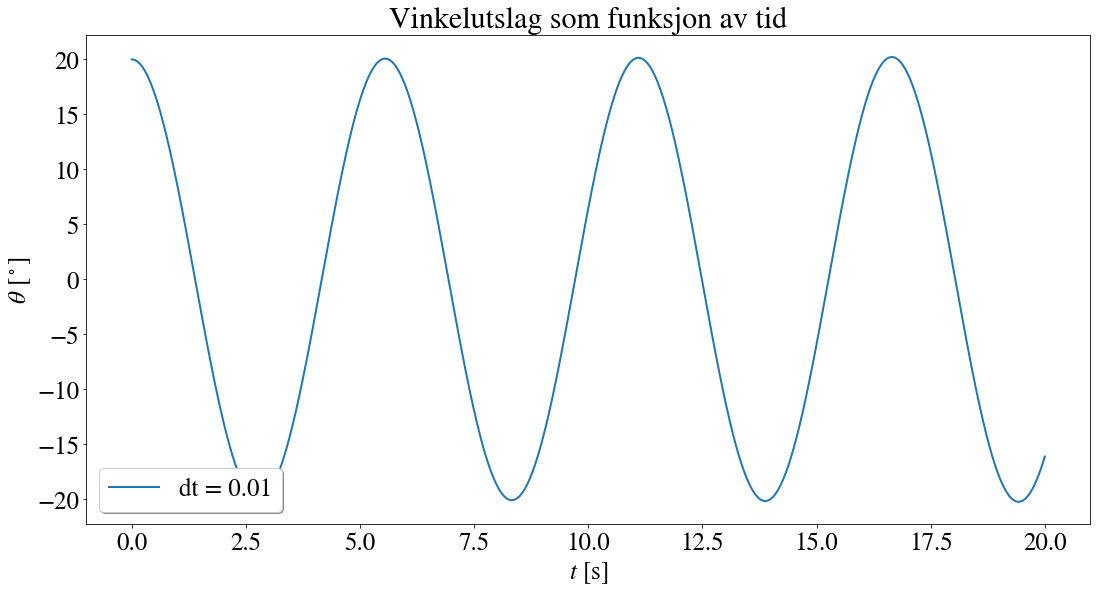

In [111]:
def test_euler():
    # f = lambda t, w: np.array([
    #     w[1],
    #     -(A_0 * sigma_0 * g * h)/calculate_I_c(0, 0) * np.sin( w[0] )
    #     ])
    
    # This function is equivalent
    def f(t, w):
        dw = np.array([
            w[1],
            -(A_0 * sigma_0 * g * h)/calculate_I_c(0, 0) * np.sin( w[0] )
        ])
        #print("w_0 that works: ", w[0])
        #print(type(w[0]))
        return dw

    # Define the inital condititons, time intervall, and step size
    theta_0 = np.array([np.radians(20)])
    omega_0 = np.array([0])
    w_0 = np.array([theta_0, omega_0]) # Combine all the initial conditions to the array w

    t_0 = 0
    t_end = 20

    h_step = 0.001  #The step size of our simulation


    # Calculate the angles and angle velocities in the given time intervall using the Euler method
    t_num, w_num = solve_ODE(f, t_0, t_end, w_0, h_step, euler_step)

    theta_num, omega_num = w_num[0:2]
    # print(f'theta:\n {theta_num}\n\nomega:\n{omega_num}')
    

    # Plot the angles vs time
    plt.plot(t_num, np.rad2deg(theta_num), label = "dt = 0.01")
    plt.title("Vinkelutslag som funksjon av tid")
    plt.xlabel('$t$ [s]')           
    plt.ylabel(r'$\theta$ [$^\circ$]')   
    # plt.ylim(-0.4,0.4)        
    plt.legend(loc=3, shadow = True)
    plt.show()

test_euler()

## Small angle approximation
...

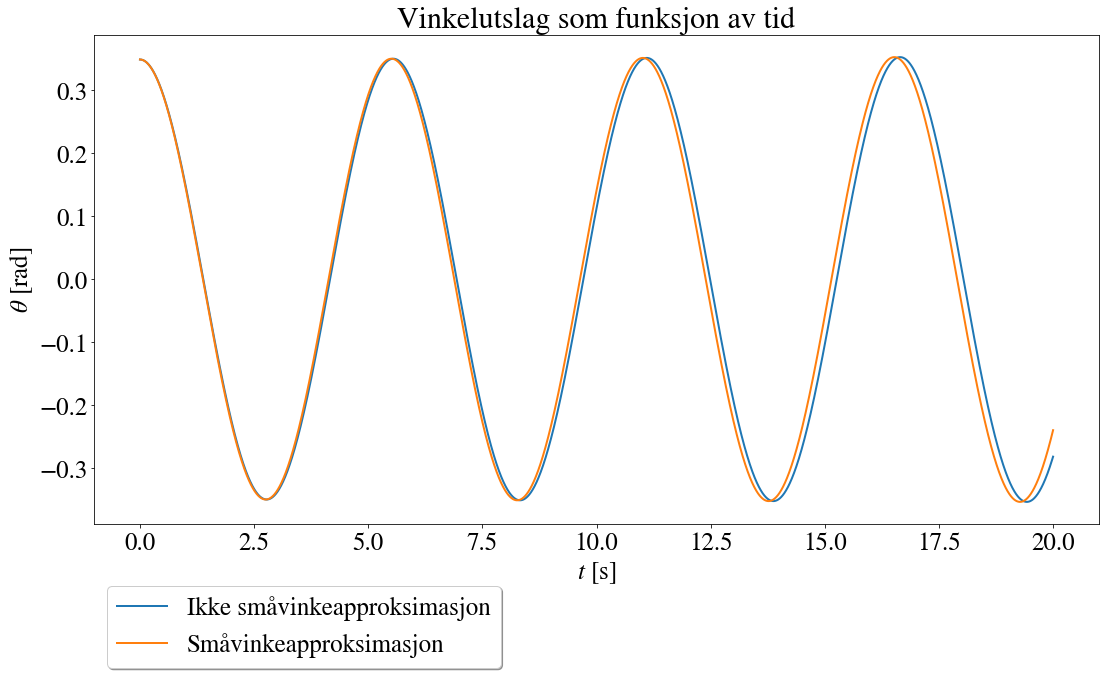

In [112]:
def angle_approx_comparison():
    # def f(t, w):
    #     const = (A_s*sigma * g * h)/calculate_I_c(0, 0)
    #     return np.array([w[1], -const*np.sin(w[0]),0,0,0,0,0,0])

    # def f_small_angle(t, w):
    #     const = (A_s*sigma * g * h)/calculate_I_c(0, 0)
    #     return np.array([w[1], -const*w[0],0,0,0,0,0,0])

    #######################################################################################
    #       Define the functions differential equations that we will be solving
    f = lambda t, w: np.array([
        w[1],
        -(A_s*sigma * g * h)/calculate_I_c(0, 0) * np.sin(w[0])
    ])
    f_small_angle = lambda t, w: np.array([
        w[1],
        -(A_s*sigma * g * h)/calculate_I_c(0, 0) * w[0]
    ])

    #######################################################################################
    #       Define the inital condititons, time intervall, and step size
    theta_0 = np.array([np.radians(20)])
    omega_0 = np.array([0])
    w_0 = np.array([theta_0, omega_0]) # Combine all the initial conditions to the array w

    t_0 = 0
    t_end = 20

    h_step = 0.001  #The step size of our simulation
    #######################################################################################
    #       Solve diff. eqn. by the given methods, and 
    t_num, w_num = solve_ODE(f, t_0, t_end, w_0, h_step, euler_step)
    t_num_small_angle_approx, w_num_small_angle_approx = solve_ODE(f_small_angle, t_0, t_end, w_0, h_step,euler_step)


    theta_num, omega_num = w_num[0:2]
    theta_num_small_angle_approx, omega_num_small_angle_approx = w_num_small_angle_approx[0:2]
    
    diff = theta_num_small_angle_approx - theta_num    


    plt.plot(t_num, theta_num, label = "Ikke småvinkeapproksimasjon")
    plt.plot(t_num_small_angle_approx, theta_num_small_angle_approx, label = "Småvinkeapproksimasjon")
    # plt.plot(t_num, diff, label = "Differanse")
    plt.title("Vinkelutslag som funksjon av tid")
    plt.xlabel('$t$ [s]')           
    plt.ylabel(r'$\theta$ [rad]')   
    # plt.ylim(-0.2,0.2)        
    plt.legend( 
        bbox_to_anchor=(0,-0.1),
        loc='upper left',
        shadow = True
        )
    plt.show()

angle_approx_comparison()

## 1.3 Runge Kutta metoden

Implementerer fjerde ordens Runge Kutta.


In [113]:
def rk4_step(f, t, w, h):
    '''
    Tar inn en vektor-funksjon på formen f(t, _w_) = _y'_ = _y_ + _g(x)_, med nåværende tid (t) og 
    tilstand (w), og regner ut ett Runge Kutta steg.
    Inn:
        f: s-array, som beskriver et system av førsteordens diff-ligninger.
        t: float, nåvernde tid
        w: s-array, som beskriver systemet
    Ut:
        t_new: neste tidssteg (t+h)
        w_new: systemet etter ett beregnet tidssteg    
    '''

    k_1 = f(t, w)
    k_2 = f(t + 0.5*h, w + h*k_1*0.5)
    k_3 = f(t + 0.5*h, w + h*k_2*0.5)
    k_4 = f(t + 1.0*h, w + h*k_3)

    w_new = w + h*(1/6) * (k_1 + 2*k_2 + 2*k_3 + k_4)
    t_new = t + h

    return t_new, w_new




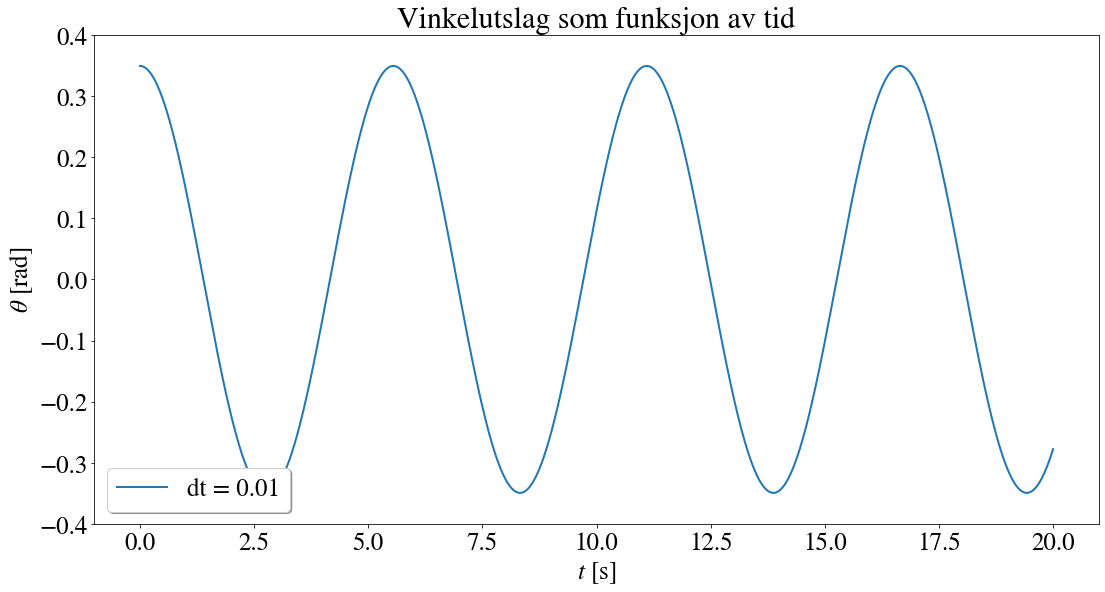

In [114]:
def test_runge_kutta():

    # def f(t, w):
    #     const = (A_s*sigma * g * h)/calculate_I_c(0, 0)
    #     return np.array([w[1], -const*np.sin(w[0]),0,0,0,0,0,0])
    
    #######################################################################################
    #       Define the functions differential equations that we will be solving
    f = lambda t, w: np.array([
        w[1],
        -(A_0 * sigma_0 * g * h)/calculate_I_c(0, 0) * np.sin( w[0] )
        ])


    #######################################################################################
    #       Define the inital condititons, time intervall, and step size
    theta_0 = np.array([np.radians(20)])
    omega_0 = np.array([0])
    w_0 = np.array([theta_0, omega_0]) # Combine all the initial conditions to the array w

    t_0 = 0
    t_end = 20

    h_step = 0.01  #The step size of our simulation
    #######################################################################################

    t_num_rk4, w_num_rk4 = solve_ODE(f, t_0, t_end, w_0, h_step, rk4_step)
    theta_num_rk4, omega_num_rk = w_num_rk4[0:2]


    plt.plot(t_num_rk4, theta_num_rk4, label = "dt = 0.01")
    plt.title("Vinkelutslag som funksjon av tid")
    plt.xlabel('$t$ [s]')           
    plt.ylabel(r'$\theta$ [rad]')   
    plt.ylim(-0.4,0.4)        
    plt.legend(loc=3, shadow = True)
    plt.show()
    

test_runge_kutta()

## 1h)
...


In [190]:
def anal_vs_num():
    #######################################################################################
    #       Define the functions differential equations that we will be solving
    def f_analytic(t):
        return 0.01*np.cos(np.sqrt((m_boat*g*h)/calculate_I_c(0, 0))*t)
    
    # To be used in numerical solutions
    f_small_angle = lambda t, w: np.array([
        w[1],
        -(A_0 * sigma_0 * g * h)/calculate_I_c(0, 0) * w[0]
        ])
    f_not_small_angle = lambda t, w: np.array([
        w[1],
        -(A_0 * sigma_0 * g * h)/calculate_I_c(0, 0) * np.sin( w[0] )
        ])
    
    # def f_small_angle(t, w):
    #     const = (A_s*sigma * g * h)/calculate_I_c(0, 0)
    #     return np.array([w[1], -const*w[0],0,0,0,0,0,0])
    # def f_not_small_angle(t, w):
    #     const = (A_s*sigma * g * h)/calculate_I_c(0, 0)
    #     return np.array([w[1], -const*  np.sin(w[0]),0,0,0,0,0,0])


    # theta_0 = np.radians(0.01)
    # omega_0 = 0
    # w_0 = np.array([theta_0, omega_0,0,0,0,0,0,0])

    # t_0 = 0
    # t_end = 20


    #######################################################################################
    #       Define the inital condititons, time intervall, the array of step sizes, 
    #       and the analytic value at t=20s
    theta_0 = np.array([0.01])
    omega_0 = np.array([0])
    w_0 = np.array([
        theta_0, 
        omega_0
        ]) # Combine all the initial conditions to the array w

    t_0 = 0
    t_end = 20

    h_steps = np.linspace(0.01, 0.06, 200)


    #######################################################################################
    #       Find the values of different methods (including analytic) at t=20s
    #       using different step sizes
    f_analytic_t_20 = f_analytic(20) # Analytic value at t=20s

    theta_t20_arr_euler = np.array([])
    theta_t20_arr_rk4 = np.array([])

    # Iterate through all the desired step sizes, and store them
    for h_step in h_steps:
        theta_euler    =   solve_ODE(f_small_angle, t_0, t_end, w_0, h_step, euler_step)[1][0] #[1]: w, [0]: theta
        theta_rk4      =   solve_ODE(f_small_angle, t_0, t_end, w_0, h_step, rk4_step)[1][0]

        # Store the angle at t=20s (the last angle)
        theta_t20_arr_euler =   np.append(theta_t20_arr_euler, theta_euler[-1])
        theta_t20_arr_rk4   =   np.append(theta_t20_arr_rk4 , theta_rk4[-1])


    difference_euler    = np.abs(theta_t20_arr_euler   -   f_analytic_t_20)
    difference_rk4      = np.abs(theta_t20_arr_rk4     -   f_analytic_t_20)
    # difference_rk4 = np.abs(difference_rk4)
    
    #######################################################################################
    #       Save the data to a file
    np.savez(
        'simulation_data/difference_at_t20',
        h_steps = h_steps,
        difference_euler = difference_euler,
        difference_rk4 = difference_rk4
        
        )
anal_vs_num()

[0.000e+00 1.000e-02 2.000e-02 ... 1.998e+01 1.999e+01 2.000e+01]
[0.000e+00 1.000e-02 2.000e-02 ... 1.998e+01 1.999e+01 2.000e+01]
[0.00000000e+00 1.02564103e-02 2.05128205e-02 ... 1.99794872e+01
 1.99897436e+01 2.00000000e+01]
[0.00000000e+00 1.02564103e-02 2.05128205e-02 ... 1.99794872e+01
 1.99897436e+01 2.00000000e+01]
[0.00000000e+00 1.05042017e-02 2.10084034e-02 ... 1.99789916e+01
 1.99894958e+01 2.00000000e+01]
[0.00000000e+00 1.05042017e-02 2.10084034e-02 ... 1.99789916e+01
 1.99894958e+01 2.00000000e+01]
[0.00000000e+00 1.07584723e-02 2.15169446e-02 ... 1.99784831e+01
 1.99892415e+01 2.00000000e+01]
[0.00000000e+00 1.07584723e-02 2.15169446e-02 ... 1.99784831e+01
 1.99892415e+01 2.00000000e+01]
[0.00000000e+00 1.10071547e-02 2.20143093e-02 ... 1.99779857e+01
 1.99889928e+01 2.00000000e+01]
[0.00000000e+00 1.10071547e-02 2.20143093e-02 ... 1.99779857e+01
 1.99889928e+01 2.00000000e+01]
[0.00000000e+00 1.12612613e-02 2.25225225e-02 ... 1.99774775e+01
 1.99887387e+01 2.00000000e

[ 0.          0.02081165  0.04162331  0.06243496  0.08324662  0.10405827
  0.12486993  0.14568158  0.16649324  0.18730489  0.20811655  0.2289282
  0.24973985  0.27055151  0.29136316  0.31217482  0.33298647  0.35379813
  0.37460978  0.39542144  0.41623309  0.43704475  0.4578564   0.47866805
  0.49947971  0.52029136  0.54110302  0.56191467  0.58272633  0.60353798
  0.62434964  0.64516129  0.66597294  0.6867846   0.70759625  0.72840791
  0.74921956  0.77003122  0.79084287  0.81165453  0.83246618  0.85327784
  0.87408949  0.89490114  0.9157128   0.93652445  0.95733611  0.97814776
  0.99895942  1.01977107  1.04058273  1.06139438  1.08220604  1.10301769
  1.12382934  1.144641    1.16545265  1.18626431  1.20707596  1.22788762
  1.24869927  1.26951093  1.29032258  1.31113424  1.33194589  1.35275754
  1.3735692   1.39438085  1.41519251  1.43600416  1.45681582  1.47762747
  1.49843913  1.51925078  1.54006243  1.56087409  1.58168574  1.6024974
  1.62330905  1.64412071  1.66493236  1.68574402  1.7

[ 0.          0.02181025  0.0436205   0.06543075  0.087241    0.10905125
  0.1308615   0.15267176  0.17448201  0.19629226  0.21810251  0.23991276
  0.26172301  0.28353326  0.30534351  0.32715376  0.34896401  0.37077426
  0.39258451  0.41439477  0.43620502  0.45801527  0.47982552  0.50163577
  0.52344602  0.54525627  0.56706652  0.58887677  0.61068702  0.63249727
  0.65430752  0.67611778  0.69792803  0.71973828  0.74154853  0.76335878
  0.78516903  0.80697928  0.82878953  0.85059978  0.87241003  0.89422028
  0.91603053  0.93784079  0.95965104  0.98146129  1.00327154  1.02508179
  1.04689204  1.06870229  1.09051254  1.11232279  1.13413304  1.15594329
  1.17775354  1.19956379  1.22137405  1.2431843   1.26499455  1.2868048
  1.30861505  1.3304253   1.35223555  1.3740458   1.39585605  1.4176663
  1.43947655  1.4612868   1.48309706  1.50490731  1.52671756  1.54852781
  1.57033806  1.59214831  1.61395856  1.63576881  1.65757906  1.67938931
  1.70119956  1.72300981  1.74482007  1.76663032  1.7

[ 0.          0.02283105  0.0456621   0.06849315  0.0913242   0.11415525
  0.1369863   0.15981735  0.1826484   0.20547945  0.2283105   0.25114155
  0.2739726   0.29680365  0.3196347   0.34246575  0.3652968   0.38812785
  0.4109589   0.43378995  0.456621    0.47945205  0.50228311  0.52511416
  0.54794521  0.57077626  0.59360731  0.61643836  0.63926941  0.66210046
  0.68493151  0.70776256  0.73059361  0.75342466  0.77625571  0.79908676
  0.82191781  0.84474886  0.86757991  0.89041096  0.91324201  0.93607306
  0.95890411  0.98173516  1.00456621  1.02739726  1.05022831  1.07305936
  1.09589041  1.11872146  1.14155251  1.16438356  1.18721461  1.21004566
  1.23287671  1.25570776  1.27853881  1.30136986  1.32420091  1.34703196
  1.36986301  1.39269406  1.41552511  1.43835616  1.46118721  1.48401826
  1.50684932  1.52968037  1.55251142  1.57534247  1.59817352  1.62100457
  1.64383562  1.66666667  1.68949772  1.71232877  1.73515982  1.75799087
  1.78082192  1.80365297  1.82648402  1.84931507  1

[ 0.          0.02409639  0.04819277  0.07228916  0.09638554  0.12048193
  0.14457831  0.1686747   0.19277108  0.21686747  0.24096386  0.26506024
  0.28915663  0.31325301  0.3373494   0.36144578  0.38554217  0.40963855
  0.43373494  0.45783133  0.48192771  0.5060241   0.53012048  0.55421687
  0.57831325  0.60240964  0.62650602  0.65060241  0.6746988   0.69879518
  0.72289157  0.74698795  0.77108434  0.79518072  0.81927711  0.84337349
  0.86746988  0.89156627  0.91566265  0.93975904  0.96385542  0.98795181
  1.01204819  1.03614458  1.06024096  1.08433735  1.10843373  1.13253012
  1.15662651  1.18072289  1.20481928  1.22891566  1.25301205  1.27710843
  1.30120482  1.3253012   1.34939759  1.37349398  1.39759036  1.42168675
  1.44578313  1.46987952  1.4939759   1.51807229  1.54216867  1.56626506
  1.59036145  1.61445783  1.63855422  1.6626506   1.68674699  1.71084337
  1.73493976  1.75903614  1.78313253  1.80722892  1.8313253   1.85542169
  1.87951807  1.90361446  1.92771084  1.95180723  1

[ 0.          0.02534854  0.05069708  0.07604563  0.10139417  0.12674271
  0.15209125  0.1774398   0.20278834  0.22813688  0.25348542  0.27883397
  0.30418251  0.32953105  0.35487959  0.38022814  0.40557668  0.43092522
  0.45627376  0.48162231  0.50697085  0.53231939  0.55766793  0.58301648
  0.60836502  0.63371356  0.6590621   0.68441065  0.70975919  0.73510773
  0.76045627  0.78580482  0.81115336  0.8365019   0.86185044  0.88719899
  0.91254753  0.93789607  0.96324461  0.98859316  1.0139417   1.03929024
  1.06463878  1.08998733  1.11533587  1.14068441  1.16603295  1.1913815
  1.21673004  1.24207858  1.26742712  1.29277567  1.31812421  1.34347275
  1.36882129  1.39416984  1.41951838  1.44486692  1.47021546  1.49556401
  1.52091255  1.54626109  1.57160963  1.59695817  1.62230672  1.64765526
  1.6730038   1.69835234  1.72370089  1.74904943  1.77439797  1.79974651
  1.82509506  1.8504436   1.87579214  1.90114068  1.92648923  1.95183777
  1.97718631  2.00253485  2.0278834   2.05323194  2.

[ 0.          0.02659574  0.05319149  0.07978723  0.10638298  0.13297872
  0.15957447  0.18617021  0.21276596  0.2393617   0.26595745  0.29255319
  0.31914894  0.34574468  0.37234043  0.39893617  0.42553191  0.45212766
  0.4787234   0.50531915  0.53191489  0.55851064  0.58510638  0.61170213
  0.63829787  0.66489362  0.69148936  0.71808511  0.74468085  0.7712766
  0.79787234  0.82446809  0.85106383  0.87765957  0.90425532  0.93085106
  0.95744681  0.98404255  1.0106383   1.03723404  1.06382979  1.09042553
  1.11702128  1.14361702  1.17021277  1.19680851  1.22340426  1.25
  1.27659574  1.30319149  1.32978723  1.35638298  1.38297872  1.40957447
  1.43617021  1.46276596  1.4893617   1.51595745  1.54255319  1.56914894
  1.59574468  1.62234043  1.64893617  1.67553191  1.70212766  1.7287234
  1.75531915  1.78191489  1.80851064  1.83510638  1.86170213  1.88829787
  1.91489362  1.94148936  1.96808511  1.99468085  2.0212766   2.04787234
  2.07446809  2.10106383  2.12765957  2.15425532  2.1808510

[ 0.          0.02785515  0.05571031  0.08356546  0.11142061  0.13927577
  0.16713092  0.19498607  0.22284123  0.25069638  0.27855153  0.30640669
  0.33426184  0.36211699  0.38997214  0.4178273   0.44568245  0.4735376
  0.50139276  0.52924791  0.55710306  0.58495822  0.61281337  0.64066852
  0.66852368  0.69637883  0.72423398  0.75208914  0.77994429  0.80779944
  0.8356546   0.86350975  0.8913649   0.91922006  0.94707521  0.97493036
  1.00278552  1.03064067  1.05849582  1.08635097  1.11420613  1.14206128
  1.16991643  1.19777159  1.22562674  1.25348189  1.28133705  1.3091922
  1.33704735  1.36490251  1.39275766  1.42061281  1.44846797  1.47632312
  1.50417827  1.53203343  1.55988858  1.58774373  1.61559889  1.64345404
  1.67130919  1.69916435  1.7270195   1.75487465  1.78272981  1.81058496
  1.83844011  1.86629526  1.89415042  1.92200557  1.94986072  1.97771588
  2.00557103  2.03342618  2.06128134  2.08913649  2.11699164  2.1448468
  2.17270195  2.2005571   2.22841226  2.25626741  2.28

[ 0.          0.02911208  0.05822416  0.08733624  0.11644833  0.14556041
  0.17467249  0.20378457  0.23289665  0.26200873  0.29112082  0.3202329
  0.34934498  0.37845706  0.40756914  0.43668122  0.4657933   0.49490539
  0.52401747  0.55312955  0.58224163  0.61135371  0.64046579  0.66957787
  0.69868996  0.72780204  0.75691412  0.7860262   0.81513828  0.84425036
  0.87336245  0.90247453  0.93158661  0.96069869  0.98981077  1.01892285
  1.04803493  1.07714702  1.1062591   1.13537118  1.16448326  1.19359534
  1.22270742  1.25181951  1.28093159  1.31004367  1.33915575  1.36826783
  1.39737991  1.42649199  1.45560408  1.48471616  1.51382824  1.54294032
  1.5720524   1.60116448  1.63027656  1.65938865  1.68850073  1.71761281
  1.74672489  1.77583697  1.80494905  1.83406114  1.86317322  1.8922853
  1.92139738  1.95050946  1.97962154  2.00873362  2.03784571  2.06695779
  2.09606987  2.12518195  2.15429403  2.18340611  2.2125182   2.24163028
  2.27074236  2.29985444  2.32896652  2.3580786   2.3

[ 0.          0.03062787  0.06125574  0.09188361  0.12251149  0.15313936
  0.18376723  0.2143951   0.24502297  0.27565084  0.30627871  0.33690658
  0.36753446  0.39816233  0.4287902   0.45941807  0.49004594  0.52067381
  0.55130168  0.58192956  0.61255743  0.6431853   0.67381317  0.70444104
  0.73506891  0.76569678  0.79632466  0.82695253  0.8575804   0.88820827
  0.91883614  0.94946401  0.98009188  1.01071975  1.04134763  1.0719755
  1.10260337  1.13323124  1.16385911  1.19448698  1.22511485  1.25574273
  1.2863706   1.31699847  1.34762634  1.37825421  1.40888208  1.43950995
  1.47013783  1.5007657   1.53139357  1.56202144  1.59264931  1.62327718
  1.65390505  1.68453292  1.7151608   1.74578867  1.77641654  1.80704441
  1.83767228  1.86830015  1.89892802  1.9295559   1.96018377  1.99081164
  2.02143951  2.05206738  2.08269525  2.11332312  2.143951    2.17457887
  2.20520674  2.23583461  2.26646248  2.29709035  2.32771822  2.35834609
  2.38897397  2.41960184  2.45022971  2.48085758  2.

[ 0.          0.03215434  0.06430868  0.09646302  0.12861736  0.1607717
  0.19292605  0.22508039  0.25723473  0.28938907  0.32154341  0.35369775
  0.38585209  0.41800643  0.45016077  0.48231511  0.51446945  0.54662379
  0.57877814  0.61093248  0.64308682  0.67524116  0.7073955   0.73954984
  0.77170418  0.80385852  0.83601286  0.8681672   0.90032154  0.93247588
  0.96463023  0.99678457  1.02893891  1.06109325  1.09324759  1.12540193
  1.15755627  1.18971061  1.22186495  1.25401929  1.28617363  1.31832797
  1.35048232  1.38263666  1.414791    1.44694534  1.47909968  1.51125402
  1.54340836  1.5755627   1.60771704  1.63987138  1.67202572  1.70418006
  1.73633441  1.76848875  1.80064309  1.83279743  1.86495177  1.89710611
  1.92926045  1.96141479  1.99356913  2.02572347  2.05787781  2.09003215
  2.1221865   2.15434084  2.18649518  2.21864952  2.25080386  2.2829582
  2.31511254  2.34726688  2.37942122  2.41157556  2.4437299   2.47588424
  2.50803859  2.54019293  2.57234727  2.60450161  2.6

[ 0.          0.03367003  0.06734007  0.1010101   0.13468013  0.16835017
  0.2020202   0.23569024  0.26936027  0.3030303   0.33670034  0.37037037
  0.4040404   0.43771044  0.47138047  0.50505051  0.53872054  0.57239057
  0.60606061  0.63973064  0.67340067  0.70707071  0.74074074  0.77441077
  0.80808081  0.84175084  0.87542088  0.90909091  0.94276094  0.97643098
  1.01010101  1.04377104  1.07744108  1.11111111  1.14478114  1.17845118
  1.21212121  1.24579125  1.27946128  1.31313131  1.34680135  1.38047138
  1.41414141  1.44781145  1.48148148  1.51515152  1.54882155  1.58249158
  1.61616162  1.64983165  1.68350168  1.71717172  1.75084175  1.78451178
  1.81818182  1.85185185  1.88552189  1.91919192  1.95286195  1.98653199
  2.02020202  2.05387205  2.08754209  2.12121212  2.15488215  2.18855219
  2.22222222  2.25589226  2.28956229  2.32323232  2.35690236  2.39057239
  2.42424242  2.45791246  2.49158249  2.52525253  2.55892256  2.59259259
  2.62626263  2.65993266  2.69360269  2.72727273  2

[ 0.          0.03539823  0.07079646  0.10619469  0.14159292  0.17699115
  0.21238938  0.24778761  0.28318584  0.31858407  0.3539823   0.38938053
  0.42477876  0.46017699  0.49557522  0.53097345  0.56637168  0.60176991
  0.63716814  0.67256637  0.7079646   0.74336283  0.77876106  0.81415929
  0.84955752  0.88495575  0.92035398  0.95575221  0.99115044  1.02654867
  1.0619469   1.09734513  1.13274336  1.16814159  1.20353982  1.23893805
  1.27433628  1.30973451  1.34513274  1.38053097  1.4159292   1.45132743
  1.48672566  1.52212389  1.55752212  1.59292035  1.62831858  1.66371681
  1.69911504  1.73451327  1.7699115   1.80530973  1.84070796  1.87610619
  1.91150442  1.94690265  1.98230088  2.01769912  2.05309735  2.08849558
  2.12389381  2.15929204  2.19469027  2.2300885   2.26548673  2.30088496
  2.33628319  2.37168142  2.40707965  2.44247788  2.47787611  2.51327434
  2.54867257  2.5840708   2.61946903  2.65486726  2.69026549  2.72566372
  2.76106195  2.79646018  2.83185841  2.86725664  2

[ 0.          0.03717472  0.07434944  0.11152416  0.14869888  0.18587361
  0.22304833  0.26022305  0.29739777  0.33457249  0.37174721  0.40892193
  0.44609665  0.48327138  0.5204461   0.55762082  0.59479554  0.63197026
  0.66914498  0.7063197   0.74349442  0.78066914  0.81784387  0.85501859
  0.89219331  0.92936803  0.96654275  1.00371747  1.04089219  1.07806691
  1.11524164  1.15241636  1.18959108  1.2267658   1.26394052  1.30111524
  1.33828996  1.37546468  1.41263941  1.44981413  1.48698885  1.52416357
  1.56133829  1.59851301  1.63568773  1.67286245  1.71003717  1.7472119
  1.78438662  1.82156134  1.85873606  1.89591078  1.9330855   1.97026022
  2.00743494  2.04460967  2.08178439  2.11895911  2.15613383  2.19330855
  2.23048327  2.26765799  2.30483271  2.34200743  2.37918216  2.41635688
  2.4535316   2.49070632  2.52788104  2.56505576  2.60223048  2.6394052
  2.67657993  2.71375465  2.75092937  2.78810409  2.82527881  2.86245353
  2.89962825  2.93680297  2.9739777   3.01115242  3.0

[ 0.          0.03891051  0.07782101  0.11673152  0.15564202  0.19455253
  0.23346304  0.27237354  0.31128405  0.35019455  0.38910506  0.42801556
  0.46692607  0.50583658  0.54474708  0.58365759  0.62256809  0.6614786
  0.70038911  0.73929961  0.77821012  0.81712062  0.85603113  0.89494163
  0.93385214  0.97276265  1.01167315  1.05058366  1.08949416  1.12840467
  1.16731518  1.20622568  1.24513619  1.28404669  1.3229572   1.3618677
  1.40077821  1.43968872  1.47859922  1.51750973  1.55642023  1.59533074
  1.63424125  1.67315175  1.71206226  1.75097276  1.78988327  1.82879377
  1.86770428  1.90661479  1.94552529  1.9844358   2.0233463   2.06225681
  2.10116732  2.14007782  2.17898833  2.21789883  2.25680934  2.29571984
  2.33463035  2.37354086  2.41245136  2.45136187  2.49027237  2.52918288
  2.56809339  2.60700389  2.6459144   2.6848249   2.72373541  2.76264591
  2.80155642  2.84046693  2.87937743  2.91828794  2.95719844  2.99610895
  3.03501946  3.07392996  3.11284047  3.15175097  3.1

[ 0.          0.04098361  0.08196721  0.12295082  0.16393443  0.20491803
  0.24590164  0.28688525  0.32786885  0.36885246  0.40983607  0.45081967
  0.49180328  0.53278689  0.57377049  0.6147541   0.6557377   0.69672131
  0.73770492  0.77868852  0.81967213  0.86065574  0.90163934  0.94262295
  0.98360656  1.02459016  1.06557377  1.10655738  1.14754098  1.18852459
  1.2295082   1.2704918   1.31147541  1.35245902  1.39344262  1.43442623
  1.47540984  1.51639344  1.55737705  1.59836066  1.63934426  1.68032787
  1.72131148  1.76229508  1.80327869  1.8442623   1.8852459   1.92622951
  1.96721311  2.00819672  2.04918033  2.09016393  2.13114754  2.17213115
  2.21311475  2.25409836  2.29508197  2.33606557  2.37704918  2.41803279
  2.45901639  2.5         2.54098361  2.58196721  2.62295082  2.66393443
  2.70491803  2.74590164  2.78688525  2.82786885  2.86885246  2.90983607
  2.95081967  2.99180328  3.03278689  3.07377049  3.1147541   3.1557377
  3.19672131  3.23770492  3.27868852  3.31967213  3.

[ 0.          0.04291845  0.08583691  0.12875536  0.17167382  0.21459227
  0.25751073  0.30042918  0.34334764  0.38626609  0.42918455  0.472103
  0.51502146  0.55793991  0.60085837  0.64377682  0.68669528  0.72961373
  0.77253219  0.81545064  0.8583691   0.90128755  0.94420601  0.98712446
  1.03004292  1.07296137  1.11587983  1.15879828  1.20171674  1.24463519
  1.28755365  1.3304721   1.37339056  1.41630901  1.45922747  1.50214592
  1.54506438  1.58798283  1.63090129  1.67381974  1.7167382   1.75965665
  1.80257511  1.84549356  1.88841202  1.93133047  1.97424893  2.01716738
  2.06008584  2.10300429  2.14592275  2.1888412   2.23175966  2.27467811
  2.31759657  2.36051502  2.40343348  2.44635193  2.48927039  2.53218884
  2.5751073   2.61802575  2.66094421  2.70386266  2.74678112  2.78969957
  2.83261803  2.87553648  2.91845494  2.96137339  3.00429185  3.0472103
  3.09012876  3.13304721  3.17596567  3.21888412  3.26180258  3.30472103
  3.34763948  3.39055794  3.43347639  3.47639485  3.51

[ 0.          0.04494382  0.08988764  0.13483146  0.17977528  0.2247191
  0.26966292  0.31460674  0.35955056  0.40449438  0.4494382   0.49438202
  0.53932584  0.58426966  0.62921348  0.6741573   0.71910112  0.76404494
  0.80898876  0.85393258  0.8988764   0.94382022  0.98876404  1.03370787
  1.07865169  1.12359551  1.16853933  1.21348315  1.25842697  1.30337079
  1.34831461  1.39325843  1.43820225  1.48314607  1.52808989  1.57303371
  1.61797753  1.66292135  1.70786517  1.75280899  1.79775281  1.84269663
  1.88764045  1.93258427  1.97752809  2.02247191  2.06741573  2.11235955
  2.15730337  2.20224719  2.24719101  2.29213483  2.33707865  2.38202247
  2.42696629  2.47191011  2.51685393  2.56179775  2.60674157  2.65168539
  2.69662921  2.74157303  2.78651685  2.83146067  2.87640449  2.92134831
  2.96629213  3.01123596  3.05617978  3.1011236   3.14606742  3.19101124
  3.23595506  3.28089888  3.3258427   3.37078652  3.41573034  3.46067416
  3.50561798  3.5505618   3.59550562  3.64044944  3.

[ 0.          0.04728132  0.09456265  0.14184397  0.1891253   0.23640662
  0.28368794  0.33096927  0.37825059  0.42553191  0.47281324  0.52009456
  0.56737589  0.61465721  0.66193853  0.70921986  0.75650118  0.80378251
  0.85106383  0.89834515  0.94562648  0.9929078   1.04018913  1.08747045
  1.13475177  1.1820331   1.22931442  1.27659574  1.32387707  1.37115839
  1.41843972  1.46572104  1.51300236  1.56028369  1.60756501  1.65484634
  1.70212766  1.74940898  1.79669031  1.84397163  1.89125296  1.93853428
  1.9858156   2.03309693  2.08037825  2.12765957  2.1749409   2.22222222
  2.26950355  2.31678487  2.36406619  2.41134752  2.45862884  2.50591017
  2.55319149  2.60047281  2.64775414  2.69503546  2.74231678  2.78959811
  2.83687943  2.88416076  2.93144208  2.9787234   3.02600473  3.07328605
  3.12056738  3.1678487   3.21513002  3.26241135  3.30969267  3.356974
  3.40425532  3.45153664  3.49881797  3.54609929  3.59338061  3.64066194
  3.68794326  3.73522459  3.78250591  3.82978723  3.8

[ 0.          0.04950495  0.0990099   0.14851485  0.1980198   0.24752475
  0.2970297   0.34653465  0.3960396   0.44554455  0.4950495   0.54455446
  0.59405941  0.64356436  0.69306931  0.74257426  0.79207921  0.84158416
  0.89108911  0.94059406  0.99009901  1.03960396  1.08910891  1.13861386
  1.18811881  1.23762376  1.28712871  1.33663366  1.38613861  1.43564356
  1.48514851  1.53465347  1.58415842  1.63366337  1.68316832  1.73267327
  1.78217822  1.83168317  1.88118812  1.93069307  1.98019802  2.02970297
  2.07920792  2.12871287  2.17821782  2.22772277  2.27722772  2.32673267
  2.37623762  2.42574257  2.47524752  2.52475248  2.57425743  2.62376238
  2.67326733  2.72277228  2.77227723  2.82178218  2.87128713  2.92079208
  2.97029703  3.01980198  3.06930693  3.11881188  3.16831683  3.21782178
  3.26732673  3.31683168  3.36633663  3.41584158  3.46534653  3.51485149
  3.56435644  3.61386139  3.66336634  3.71287129  3.76237624  3.81188119
  3.86138614  3.91089109  3.96039604  4.00990099  4

[ 0.          0.05181347  0.10362694  0.15544041  0.20725389  0.25906736
  0.31088083  0.3626943   0.41450777  0.46632124  0.51813472  0.56994819
  0.62176166  0.67357513  0.7253886   0.77720207  0.82901554  0.88082902
  0.93264249  0.98445596  1.03626943  1.0880829   1.13989637  1.19170984
  1.24352332  1.29533679  1.34715026  1.39896373  1.4507772   1.50259067
  1.55440415  1.60621762  1.65803109  1.70984456  1.76165803  1.8134715
  1.86528497  1.91709845  1.96891192  2.02072539  2.07253886  2.12435233
  2.1761658   2.22797927  2.27979275  2.33160622  2.38341969  2.43523316
  2.48704663  2.5388601   2.59067358  2.64248705  2.69430052  2.74611399
  2.79792746  2.84974093  2.9015544   2.95336788  3.00518135  3.05699482
  3.10880829  3.16062176  3.21243523  3.2642487   3.31606218  3.36787565
  3.41968912  3.47150259  3.52331606  3.57512953  3.62694301  3.67875648
  3.73056995  3.78238342  3.83419689  3.88601036  3.93782383  3.98963731
  4.04145078  4.09326425  4.14507772  4.19689119  4.

[ 0.          0.05434783  0.10869565  0.16304348  0.2173913   0.27173913
  0.32608696  0.38043478  0.43478261  0.48913043  0.54347826  0.59782609
  0.65217391  0.70652174  0.76086957  0.81521739  0.86956522  0.92391304
  0.97826087  1.0326087   1.08695652  1.14130435  1.19565217  1.25
  1.30434783  1.35869565  1.41304348  1.4673913   1.52173913  1.57608696
  1.63043478  1.68478261  1.73913043  1.79347826  1.84782609  1.90217391
  1.95652174  2.01086957  2.06521739  2.11956522  2.17391304  2.22826087
  2.2826087   2.33695652  2.39130435  2.44565217  2.5         2.55434783
  2.60869565  2.66304348  2.7173913   2.77173913  2.82608696  2.88043478
  2.93478261  2.98913043  3.04347826  3.09782609  3.15217391  3.20652174
  3.26086957  3.31521739  3.36956522  3.42391304  3.47826087  3.5326087
  3.58695652  3.64130435  3.69565217  3.75        3.80434783  3.85869565
  3.91304348  3.9673913   4.02173913  4.07608696  4.13043478  4.18478261
  4.23913043  4.29347826  4.34782609  4.40217391  4.456521

 19.77272727 19.82954545 19.88636364 19.94318182 20.        ]
[ 0.          0.05681818  0.11363636  0.17045455  0.22727273  0.28409091
  0.34090909  0.39772727  0.45454545  0.51136364  0.56818182  0.625
  0.68181818  0.73863636  0.79545455  0.85227273  0.90909091  0.96590909
  1.02272727  1.07954545  1.13636364  1.19318182  1.25        1.30681818
  1.36363636  1.42045455  1.47727273  1.53409091  1.59090909  1.64772727
  1.70454545  1.76136364  1.81818182  1.875       1.93181818  1.98863636
  2.04545455  2.10227273  2.15909091  2.21590909  2.27272727  2.32954545
  2.38636364  2.44318182  2.5         2.55681818  2.61363636  2.67045455
  2.72727273  2.78409091  2.84090909  2.89772727  2.95454545  3.01136364
  3.06818182  3.125       3.18181818  3.23863636  3.29545455  3.35227273
  3.40909091  3.46590909  3.52272727  3.57954545  3.63636364  3.69318182
  3.75        3.80681818  3.86363636  3.92045455  3.97727273  4.03409091
  4.09090909  4.14772727  4.20454545  4.26136364  4.31818182  4.375

 20.        ]
[ 0.          0.05952381  0.11904762  0.17857143  0.23809524  0.29761905
  0.35714286  0.41666667  0.47619048  0.53571429  0.5952381   0.6547619
  0.71428571  0.77380952  0.83333333  0.89285714  0.95238095  1.01190476
  1.07142857  1.13095238  1.19047619  1.25        1.30952381  1.36904762
  1.42857143  1.48809524  1.54761905  1.60714286  1.66666667  1.72619048
  1.78571429  1.8452381   1.9047619   1.96428571  2.02380952  2.08333333
  2.14285714  2.20238095  2.26190476  2.32142857  2.38095238  2.44047619
  2.5         2.55952381  2.61904762  2.67857143  2.73809524  2.79761905
  2.85714286  2.91666667  2.97619048  3.03571429  3.0952381   3.1547619
  3.21428571  3.27380952  3.33333333  3.39285714  3.45238095  3.51190476
  3.57142857  3.63095238  3.69047619  3.75        3.80952381  3.86904762
  3.92857143  3.98809524  4.04761905  4.10714286  4.16666667  4.22619048
  4.28571429  4.3452381   4.4047619   4.46428571  4.52380952  4.58333333
  4.64285714  4.70238095  4.76190476  4

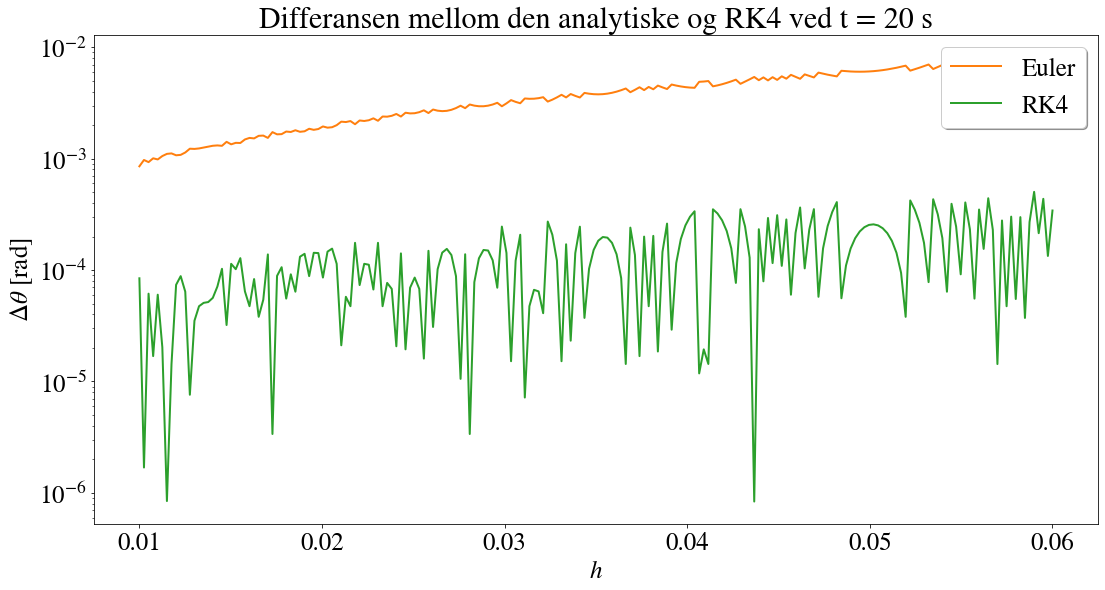

In [191]:

#######################################################################################
#       Plot the differences
def plot_difference():
    
    diff_data = np.load('simulation_data/difference_at_t20.npz')
    h_steps, difference_euler, difference_rk4 = diff_data['h_steps'], diff_data['difference_euler'], diff_data['difference_rk4']

    plt.yscale("log")
    plt.plot(h_steps, np.zeros(len(h_steps)),linestyle='--') # Stiplet linje i 0
    plt.plot(h_steps, difference_euler, label = "Euler")
    plt.plot(h_steps, difference_rk4, label = "RK4")

    plt.title("Differansen mellom den analytiske og RK4 ved t = 20 s")
    plt.xlabel('$h$')           
    plt.ylabel(r'$\Delta\theta$ [rad]')   
    #plt.ylim(-0.2,0.2)        
    plt.legend(loc=1, shadow = True)
    plt.show()


    # plt.yscale("log")
    # plt.plot(h_steps, np.zeros(len(h_steps)),linestyle='--') # Stiplet linje i 0
    # plt.plot(h_steps, difference_euler, label = "Euler")
    # plt.plot(h_steps, difference_rk4, label = "RK4")

    # plt.title("Differansen mellom den analytiske og RK4 ved t = 20 s")
    # plt.xlabel('$h$')           
    # plt.ylabel(r'$\Delta\theta$ [rad]')

    # plt.legend(loc=2, shadow = True)
    # plt.show()

plot_difference()

## 2b

beta =  2.309881463499782


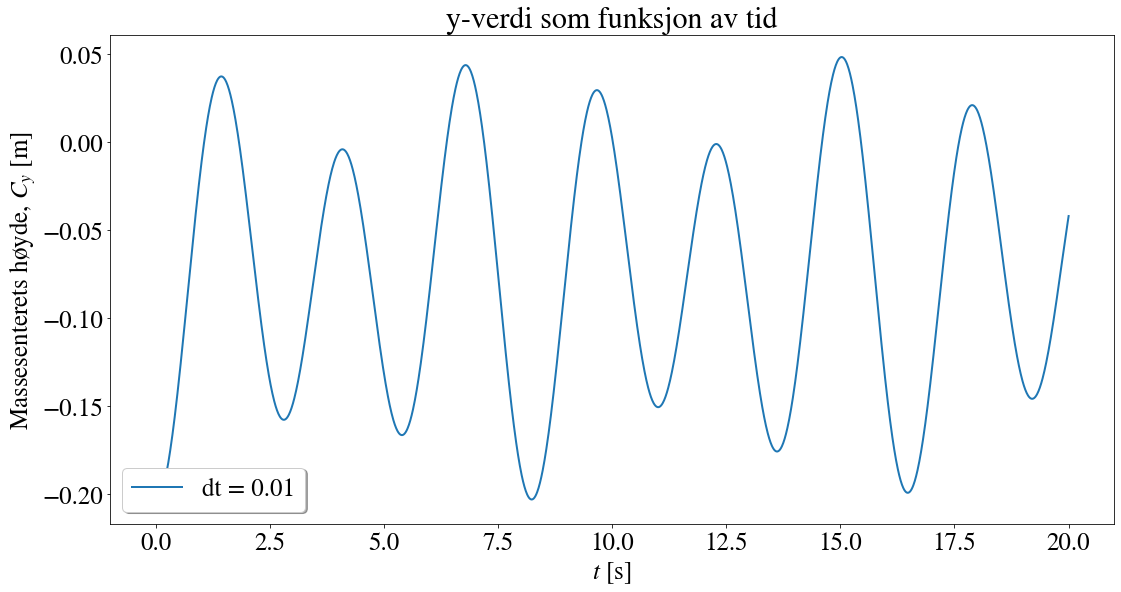

In [124]:
def cm_plot():
    beta = calculate_beta(np.pi*sigma/sigma_0, 5) # Guess 5 for initial beta
    print("beta = ",beta)
    
    def f(t, w):  
        '''
        Funksjon som brukes til å regne ut endringen til systemet.
        Inn:
            t: float, tid
            w: s-array, beskriver diverse av systemets fysiske egenskaper
        Ut:
            dw: endringen i w i det neste tidssteget
        
        '''
        #print("2b: y val: ", w[3])
        delta_y_c_current = w[3] - y_C_0(beta) 
        #print("Delta y ", delta_y_c_current)
        #print("theta: ", w[0])

        gamma_current = 2*np.arccos(np.cos(beta/2) - (4/(3*np.pi))*(1-np.cos(w[0])) + delta_y_c_current/R)

        A = water_area(gamma_current)
       
        d_theta = w[1]
        d_omega = -((F_B(A) * h)/calculate_I_c(0, 0))*np.sin(w[0])
        d_x     = w[4]
        d_y     = w[5]
        d_v_x   = np.array([0])
        d_v_y   = (F_G(m_boat) + F_B(A))/m_boat



        dw = np.array([
            d_theta,
            d_omega,
            d_x,
            d_y,   
            d_v_x,  
            d_v_y
             
        ])
        
        
        return dw

    theta_0 = np.array([np.radians(20)])
    omega_0 = np.array([np.radians(0)])
    x_C_0 = np.array([0])
    initial_y_C = np.array([y_C_0(beta)])
    v_x_0 = np.array([0])
    v_y_0 = np.array([0])



    w_0 = np.array([
        theta_0, 
        omega_0, 
        x_C_0, 
        initial_y_C, 
        v_x_0, 
        v_y_0
        ])



    t_0 = 0
    t_end = 20

    h_step = 0.01

    t_num_rk4, w_num_rk4 = solve_ODE(f, t_0, t_end, w_0, h_step, rk4_step)
    np.savez('simulation_data/rk4_water_move',t_num_rk4=t_num_rk4,w_num_rk4=w_num_rk4)

    y_num_rk4 = w_num_rk4[3]
    
    plt.plot(t_num_rk4, y_num_rk4, label = "dt = 0.01")
    plt.title("y-verdi som funksjon av tid")
    plt.xlabel('$t$ [s]')           
    plt.ylabel(r'Massesenterets høyde, $C_y$ [m]')   
    # plt.ylim(-0.25,0.25)        
    plt.legend(loc=3, shadow = True)
    plt.show()

cm_plot()

## Oppg 2c



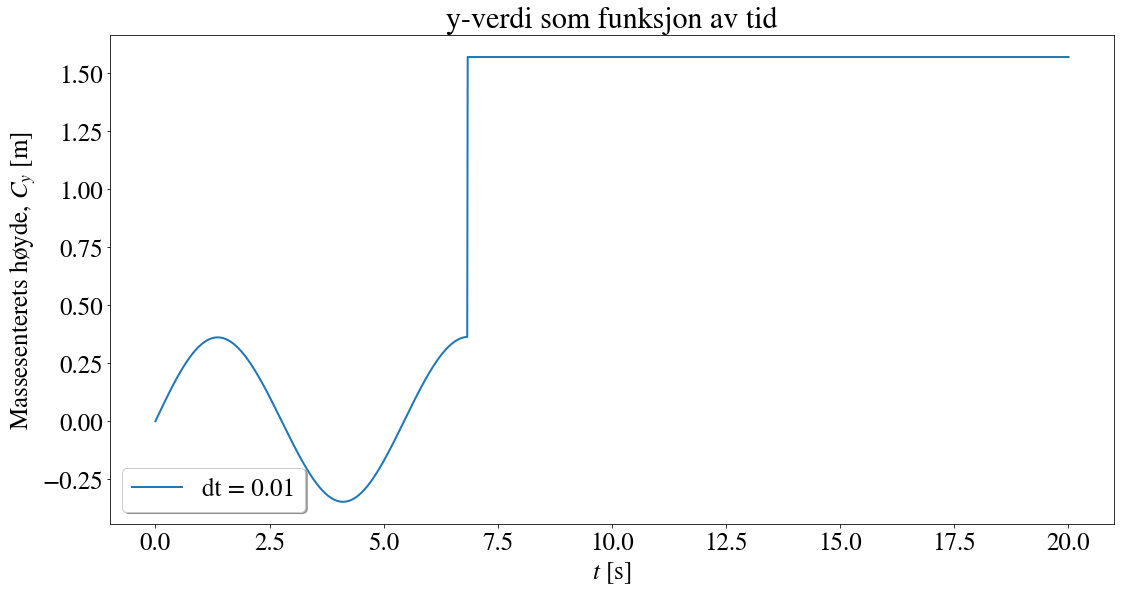

In [181]:
def check_capsizing(w_num):
    '''
    Checks if the boat is capsizing. 
    Input:
    w_num: array with all the physical properties of the boat
    output:
    w_num: Same array, but now updated values if the boat has capsized.
    
    '''
    beta = calculate_beta(np.pi*sigma/sigma_0, 5) # Guess 5 for initial beta

    theta_arr = w_num[0]
    y_arr = w_num[3]
    for i in range(len(theta_arr)-1):
        theta_n = theta_arr[i]
        delta_y_n= y_arr[i+1]-y_arr[i]
        delta_y_c_n = y_C(beta,delta_y_n)
        if theta_n > 0.5*(np.pi-gamma(beta,theta_n,delta_y_c_n,)): #Sjekk om båten kantrer
        
            
            theta_arr[i+1] = np.pi/2 * np.sign(theta_arr[i])
           
            for j in range(1,(len(w_num))):
                w_num[j]=0
    return w_num
    
def cm_plot_c():
    beta = calculate_beta(np.pi*sigma/sigma_0, 5) # Guess 5 for initial beta
    
    def f(t, w):  
        '''
        Funksjon som brukes til å regne ut endringen til systemet.
        Inn:
            t: float, tid
            w: s-array, beskriver diverse av systemets fysiske egenskaper
        Ut:
            dw: endringen i w i det neste tidssteget
        
        '''
    
        delta_y_c_current = w[3] - y_C_0(beta)  
        # print("cm_plot_c w3",w[3])
        # print("gamma innmat: ", np.cos(beta/2) - (4/(3*np.pi))*(1-np.cos(w[0])) + delta_y_c_current/R)
        gamma_current = 2*np.arccos(np.cos(beta/2) - (4/(3*np.pi))*(1-np.cos(w[0])) + delta_y_c_current/R)

        A = water_area(gamma_current)
       
        d_theta = w[1]
        d_omega = -((F_B(A) * h)/calculate_I_c(0, 0))*np.sin(w[0])
        d_x     = w[4]
        d_y     = w[5]
        d_v_x   = np.array([0])
        d_v_y   = (F_G(m_boat) + F_B(A))/m_boat


        dw = np.array([
            d_theta,
            d_omega,
            d_x,
            d_y,   
            d_v_x,  
            d_v_y 
        ])
        
        
        return dw

    theta_0 = np.array([np.radians(0)])
    omega_0 = np.array([np.radians(23.8)])
    x_C_0 = np.array([0])
    initial_y_C = np.array([y_C_0(beta)])
    v_x_0 = np.array([0])
    v_y_0 = np.array([0])

    w_0 = np.array([
        theta_0, 
        omega_0, 
        x_C_0, 
        initial_y_C, 
        v_x_0, 
        v_y_0
    ])

    t_0 = 0
    t_end = 20

    h_step = 0.01

    t_num_rk4, w_num_rk4 = solve_ODE(f, t_0, t_end, w_0, h_step, rk4_step)
    # print(w_num_rk4[0])
    w_num_rk4 = check_capsizing(w_num_rk4)
    theta_arr = w_num_rk4[0]
    # print(theta_arr)

    np.savez('simulation_data/rk4_water_move',t_num_rk4=t_num_rk4,w_num_rk4=w_num_rk4)

    y_num_rk4 = w_num_rk4[3]
    plt.plot(t_num_rk4, theta_arr, label = "dt = 0.01")
    plt.title("y-verdi som funksjon av tid")
    plt.xlabel('$t$ [s]')           
    plt.ylabel(r'Massesenterets høyde, $C_y$ [m]')   
    # plt.ylim(-0.25,0.25)        
    plt.legend(loc=3, shadow = True)
    plt.show()

cm_plot_c()


In [18]:
# def cm_plot_capsizing():
#     beta = calculate_beta(np.pi*sigma/sigma_0, 5) # Guess 5 for initial beta
#     print(beta)
#     print(np.degrees(beta))
#     def f(t, w):  
#         '''
#         Funksjon som brukes til å regne ut de nye verdiene til w-arrayet.
#         Inn:
#             t: float, tid
#             w: s-array, beskriver diverse av systemets fysiske egenskaper
#         Ut:
#             w-arrayet med oppdaterte verdier
        
#         '''
    
#         delta_y_c_current = w[3] - y_C_0(beta)  
#         print(w[3])

#         #print("arccos innmat: ",np.cos(beta/2) - (4/(3*np.pi))*(1-np.cos(w[0])) + delta_y_c_current/R)
#         gamma_current = 2*np.arccos(np.cos(beta/2) - (4/(3*np.pi))*(1-np.cos(w[0])) + delta_y_c_current/R)

#         A = water_area(gamma_current)
#         return np.array([w[1], -((F_B(A) * h)/calculate_I_c(0, 0))*np.sin(w[0]), w[4], w[5], np.array([0]), (F_G(m_boat) + F_B(A))/m_boat])


#     theta_0 = np.array([np.radians(0)])
#     omega_0 = np.array([30.8])
#     x_C_0 = np.array([0])
#     initial_y_C = np.array([y_C_0(beta)])
#     v_x_0 = np.array([0])
#     v_y_0 = np.array([0])



#     w_0 = np.array([theta_0, omega_0, x_C_0, initial_y_C, v_x_0, v_y_0])

#     t_0 = 0
#     t_end = 20

#     h_step = 0.01

#     t_num_rk4, w_num_rk4 = solve_ODE(f, t_0, t_end, w_0, h_step, rk4_step)
#     w_num_rk4 = check_capsizing(w_num_rk4)
#     theta_arr = w_num_rk4[0]
#     np.savez('simulation_data/rk4_water_move',t_num_rk4=t_num_rk4,w_num_rk4=w_num_rk4)

#     plt.plot(t_num_rk4, theta_arr, label = "dt = 0.01")
#     plt.title("Vinkelutslag som funksjon av tid")
#     plt.xlabel('$t$ [s]')           
#     plt.ylabel(r'Massesenterets høyde, $C_y$ [m]')   
#     # plt.ylim(-0.25,0.25)        
#     plt.legend(loc=3, shadow = True)
#     plt.show()

# cm_plot_capsizing()

## Oppg 2d

In [125]:
def boat_with_load():
        
    def f(t, w):  
        '''
        Funksjon som brukes til å regne ut de nye verdiene til w-arrayet.
        Inn:
            t: float, tid
            w: s-array, beskriver diverse av systemets fysiske egenskaper
        Ut:
            w-arrayet med oppdaterte verdier
        
        '''
        m_load = 0.2*m_boat #Gjør om til array senere, evt som input til funksjonen
        m_tot = m_boat + m_load
        
        beta = calculate_beta(np.pi*sigma/sigma_0 + 2*m_load/(sigma_0 * R**2),5) #Ikke lenger samme som før
        print("beta = ", np.degrees(beta))

        A = (np.pi * R**2 *sigma + 2*m_load)/(2*sigma_0) #eller A_0?
        
        delta_y_c_current = w[3] - y_C_0(beta) 
        I_c = calculate_I_c(m_tot,)
        gamma_current = 2*np.arccos(np.cos(beta/2) - (4/(3*np.pi))*(1-np.cos(w[0])) + delta_y_c_current/R)

        # A = water_area(gamma_current) #gammel
        return np.array([w[1],    -((F_B(A) * h)/I_c)*np.sin(w[0] ), w[4], w[5], 0, (F_G(m_tot) + F_B(A))/m_tot,0,0])


    def plot_with_load():
        theta_0 = np.radians(0)
        omega_0 = np.radians(23.8) #Rundt her et sted, men sjekk med newtons metode på ligningen hvis det er mulig
        x_C_0 = 0
        v_x_0 = 0
        v_y_0 = 0

        w_0 = np.array([theta_0, omega_0, x_C_0, y_C_0, v_x_0, v_y_0,0,0])

        t_0 = 0
        t_end = 20

        h_step = 0.01

        t_num_rk4, w_num_rk4 = solve_ODE(f, t_0, t_end, w_0, h_step, rk4_step)
        w_num_rk4 = check_capsizing(w_num_rk4)
        theta_arr = w_num_rk4[:,0]
        np.savez('simulation_data/rk4_water_move',t_num_rk4=t_num_rk4,w_num_rk4=w_num_rk4)

        plt.plot(t_num_rk4, theta_arr, label = "dt = 0.01")
        plt.title("Vinkelutslag som funksjon av tid")
        plt.xlabel('$t$ [s]')           
        plt.ylabel(r'Massesenterets høyde, $C_y$ [m]')   
        # plt.ylim(-0.25,0.25)        
        plt.legend(loc=3, shadow = True)
        plt.show()
    plot_with_load()
    
#boat_with_load()

## 2f
...

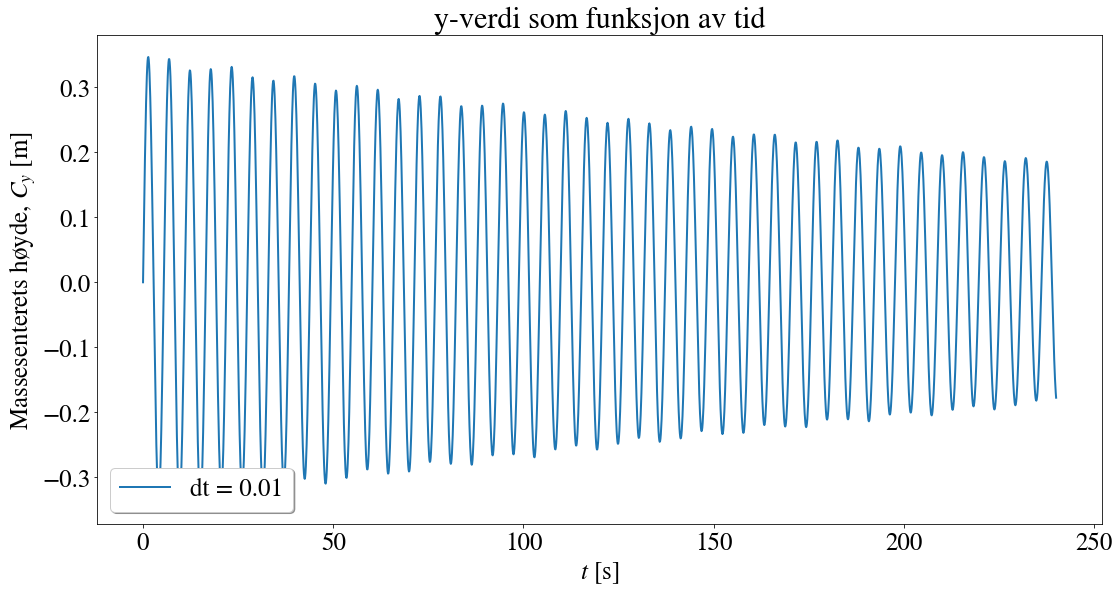

In [167]:
def wind_and_friction(F_0, k_f, omega_0_imput):
    beta = calculate_beta(np.pi*sigma/sigma_0, 5) # Guess 5 for initial beta
    
    #k_f = 1000
    omega_0 = np.sqrt((m_boat*g*h)/calculate_I_c(0, 0))
    omega_w = 0.93*omega_0
    
    def f(t, w):  
        '''
        Funksjon som brukes til å regne ut endringen til systemet.
        Inn:
            t: float, tid
            w: s-array, beskriver diverse av systemets fysiske egenskaper
        Ut:
            dw: endringen i w i det neste tidssteget
        
        '''
    
        delta_y_c_current = w[3] - y_C_0(beta)  
        # print("cm_plot_c w3",w[3])
        # print("gamma innmat: ", np.cos(beta/2) - (4/(3*np.pi))*(1-np.cos(w[0])) + delta_y_c_current/R)
        gamma_current = 2*np.arccos(np.cos(beta/2) - (4/(3*np.pi))*(1-np.cos(w[0])) + delta_y_c_current/R)

        A = water_area(gamma_current)
       
        F_w = F_0*np.cos(t*omega_w)
        current_friction = friction(k_f, w[1], gamma_current)
    
        d_theta = w[1]
        d_omega = (1/calculate_I_c(0, 0))*(-F_B(A)*h*np.sin(w[0]) + F_w*w[3] + current_friction*(w[3] - (R*(np.cos(gamma_current/2) - 1))))
        d_x     = w[4]
        d_y     = w[5]
        d_v_x   = (1/m_boat)*(current_friction + F_w)
        d_v_y   = (1/m_boat)*(F_G(m_boat) + F_B(A))

        dw = np.array([
            d_theta,
            d_omega,
            d_x,
            d_y,   
            d_v_x,  
            d_v_y 
        ])
        
        
        return dw

    theta_0 = np.array([np.radians(0)])
    omega_0 = np.array([np.radians(omega_0_imput)])
    #omega_0 = np.array([0.4])
    x_C_0 = np.array([0])
    initial_y_C = np.array([y_C_0(beta)])
    v_x_0 = np.array([0])
    v_y_0 = np.array([0])

    w_0 = np.array([
        theta_0, 
        omega_0, 
        x_C_0, 
        initial_y_C, 
        v_x_0, 
        v_y_0
    ])

    t_0 = 0
    t_end = 240

    h_step = 0.1

    t_num_rk4, w_num_rk4 = solve_ODE(f, t_0, t_end, w_0, h_step, rk4_step)
    # print(w_num_rk4[0])
    w_num_rk4 = check_capsizing(w_num_rk4)
    theta_arr = w_num_rk4[0]
    # print(theta_arr)

    np.savez('simulation_data/rk4_water_move',t_num_rk4=t_num_rk4,w_num_rk4=w_num_rk4)

    y_num_rk4 = w_num_rk4[3]
    plt.plot(t_num_rk4, theta_arr, label = "dt = 0.01")
    plt.title("y-verdi som funksjon av tid")
    plt.xlabel('$t$ [s]')           
    plt.ylabel(r'Massesenterets høyde, $C_y$ [m]')   
    # plt.ylim(-0.25,0.25)        
    plt.legend(loc=3, shadow = True)
    plt.show()

    
F_0 = 0*m_boat*g
k_f = 100
wind_and_friction(F_0, k_f, 0.4)

## 2g

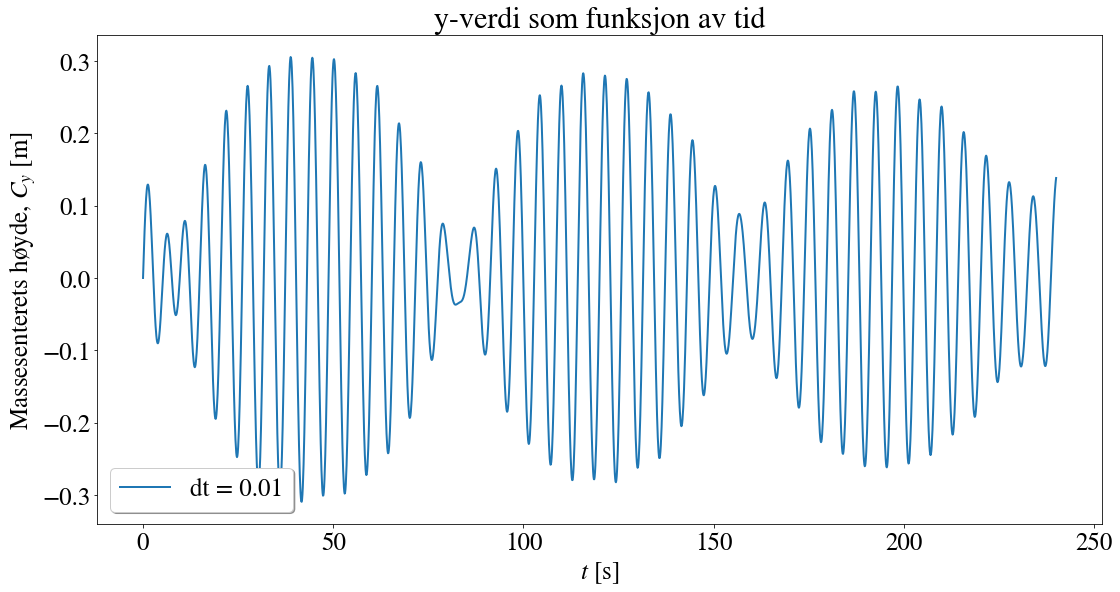

In [163]:
F_0 = 0.625*m_boat*g
k_f = 100
omega_0 = 10

wind_and_friction(F_0, k_f, omega_0)

# X.0 Conclusion

Lorem Ipsum...